In [1]:
import tensorflow as tf

2023-08-18 20:15:01.910102: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-18 20:15:01.961338: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-18 20:15:03.299621: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.__version__

'2.13.0'

In [3]:
import glob
# import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
# from tensorflow.python.keras import layers
from tensorflow.keras import layers, activations
import time
import nibabel as nib
from tqdm import tqdm
import gc
from scipy.ndimage import binary_erosion
from IPython import display

import model

In [4]:
subjects = [ f.name for f in os.scandir('./Data') if f.is_dir() and f.name != '.ipynb_checkpoints']

# subjects = ['390645', '120111']

e_or_o = 1

p_size_i = 5
p_size_o = 3

print(subjects)

['390645', '545345', '106016', '120111', '101915', '351938', '705341']


In [5]:
subjects_lr = []
subjects_hr = []
subjects_masks = []

subjects_preproc_values_lr = []
subjects_preproc_values_hr = []

subjects_t1_preproc_values = []

for subj in subjects:

    h4_imgs = []
    h4_imgs_lr = []
    dti_imgs = []
    dti_imgs_lr = []

    # DTI normalisation metrics pre-normalisation (storing max and min values in the mask) - Store for HR only
    dti_preprocs_hr = np.zeros((6,2))
    dti_preprocs_lr = np.zeros((6,2))

    print("Loading Subject {}".format(subj))
    
    for i in range(1,9):
    
        dti_data = np.array(nib.load("Data/{}/T1w/Diffusion/dt_all_{}.nii".format(subj,i)).get_fdata())
        dti_data_lr = np.array(nib.load("Data/{}/T1w/Diffusion/dt_all_lowres_2_{}.nii".format(subj,i)).get_fdata())
    
        # if i > 1:
        #     dti_data[dti_imgs[0] < 0] = 0
        #     dti_data_lr[dti_imgs[0] < 0] = 0
    
        dti_imgs.append(dti_data)
        dti_imgs_lr.append(dti_data_lr)
    
        dti_data = None
        dti_data_lr = None
    
    for i in range(1,25):
    
        h4_data = np.array(nib.load("Data/{}/T1w/Diffusion/h4_all_{}.nii".format(subj,str(i).zfill(2))).get_fdata())
        h4_data_lr = np.array(nib.load("Data/{}/T1w/Diffusion/h4_all_lowres_2_{}.nii".format(subj,str(i).zfill(2))).get_fdata())
    
        # if i > 1:
        #     h4_data[h4_data[0] < 0] = 0
        #     h4_data_lr[h4_data[0] < 0] = 0
        
        h4_imgs.append(h4_data)
        h4_imgs_lr.append(h4_data_lr)
    
        h4_data = None
        h4_data_lr = None
    
    h4_imgs = np.array(h4_imgs).transpose((1,2,3,0))
    h4_imgs_lr = np.array(h4_imgs_lr).transpose((1,2,3,0))
    
    dti_imgs = np.array(dti_imgs).transpose((1,2,3,0))
    dti_imgs_lr = np.array(dti_imgs_lr).transpose((1,2,3,0))
    
    mask = h4_imgs[...,0]

    binmask = np.zeros(mask.shape)

    binmask[mask >= 0] = 1

    mask = binary_erosion(binmask, structure=np.ones((5,5,5),np.uint8),iterations = 1)

    binmask = None

    # Calculate DTI ranges and normalise to range [0,1]
    for i in range(2,8):

        dti_preprocs_lr[i-2,:] = np.array([np.min(mask*dti_imgs_lr[...,i]), np.max(mask*dti_imgs_lr[...,i])])
        dti_imgs_lr[mask>0, i] = (dti_imgs_lr[mask>0, i] - dti_preprocs_lr[i-2,0] + 0.0001) / (dti_preprocs_lr[i-2,1] - dti_preprocs_lr[i-2,0])
        dti_imgs_lr[mask==0, i] = 0

        dti_preprocs_hr[i-2,:] = np.array([np.min(mask*dti_imgs[...,i]), np.max(mask*dti_imgs[...,i])])
        dti_imgs[mask>0, i] = (dti_imgs[mask>0, i] - dti_preprocs_hr[i-2,0] + 0.0001) / (dti_preprocs_hr[i-2,1] - dti_preprocs_hr[i-2,0])
        dti_imgs[mask==0, i] = 0


    t1w = nib.load("Data/{}/T1w/Diffusion/t1w.nii".format(subj))
    
    t1w_data = np.array(t1w.get_fdata())
    
    t1w_data_format = np.concatenate(
        (t1w_data[::2,::2,::2, None], t1w_data[::2,::2,1::2, None],
         t1w_data[::2,1::2,::2, None], t1w_data[::2,1::2,1::2, None],
         t1w_data[1::2,::2,::2, None], t1w_data[1::2,::2,1::2, None],
         t1w_data[1::2,1::2,::2, None], t1w_data[1::2,1::2,1::2, None]),
        axis=-1)

    t1w_preprocs = np.array([np.min(t1w_data_format*mask[...,None]), np.max(t1w_data_format*mask[...,None])])
    
    subjects_t1_preproc_values.append(t1w_preprocs)    
    t1w_data_format[mask>0, :] = (t1w_data_format[mask>0, :] - t1w_preprocs[0] + 0.0001) / (t1w_preprocs[1] - t1w_preprocs[0])

    subjects_preproc_values_lr.append(dti_preprocs_lr)
    subjects_preproc_values_hr.append(dti_preprocs_hr)

    lowres_input = np.concatenate((dti_imgs_lr[...,2:], t1w_data_format), axis=-1)
    hires_output = np.copy(dti_imgs[...,2:])
    
    # lowres_input = np.concatenate((h4_imgs_lr[...,2:], dti_imgs_lr[...,2:], t1w_data_format), axis=-1)
    # hires_output = np.copy(h4_imgs[...,2:])

    subjects_lr.append(lowres_input)
    subjects_hr.append(hires_output)
    subjects_masks.append(mask)


Loading Subject 390645
Loading Subject 545345
Loading Subject 106016
Loading Subject 120111
Loading Subject 101915
Loading Subject 351938
Loading Subject 705341


In [6]:
print(np.max(subjects_lr[1][...,60,5]))

0.8909749495986521


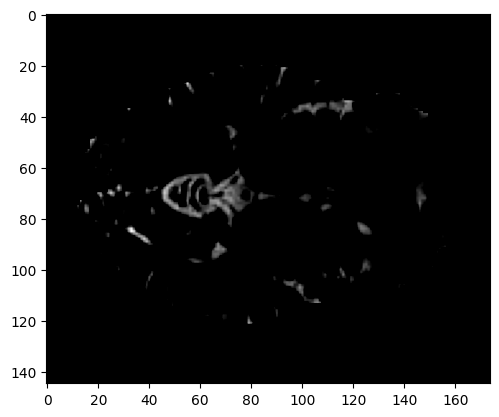

In [7]:
plt.imshow(subjects_hr[1][:,:,60,5], cmap='gray', vmin=0.5)

In [8]:
# input_layer = tf.keras.Input(shape=(32, 32, 32, 36))
# output_layer = model.unet3d(input_layer, 36)

# generator = tf.keras.Model(input_layer, output_layer)
generator = model.simple_generator(14,6,2*p_size_i+e_or_o)
discriminator = model.simple_discriminator(6,2*p_size_o+e_or_o)

2023-08-18 20:15:23.996944: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-18 20:15:24.018509: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-18 20:15:24.018693: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

(None, 7, 7, 7, 6)
(None, 1)


In [9]:
# cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

cross_entropy_gen = tf.keras.losses.BinaryCrossentropy()
cross_entropy_disc = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy_gen(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy_gen(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy_gen(tf.ones_like(fake_output), fake_output)

# cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits

# def discriminator_loss(real_output, fake_output):
#     real_loss = tf.reduce_mean(cross_entropy(labels=tf.ones_like(real_output), logits=real_output))
#     fake_loss = tf.reduce_mean(cross_entropy(labels=tf.zeros_like(fake_output), logits=fake_output))
#     total_loss = real_loss + fake_loss
#     return total_loss

# def generator_loss(fake_output):
#     return cross_entropy(labels=tf.ones_like(fake_output), logits=fake_output)

In [10]:
generator_optimizer = tf.keras.optimizers.Adam(1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

In [11]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [12]:
@tf.function
def train_step(lr_patch, hr_patch):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(lr_patch, training=True)

      real_output = discriminator(hr_patch, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

@tf.function
def train_step_gen(lr_patch, hr_patch):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        generated_images = generator(lr_patch, training=True)

        real_output = discriminator(hr_patch, training=False)
        fake_output = discriminator(generated_images, training=False)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    return gen_loss, disc_loss

@tf.function
def train_step_disc(lr_patch, hr_patch):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        generated_images = generator(lr_patch, training=False)

        real_output = discriminator(hr_patch, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [13]:
def train(data, epochs):

  gen_train_mode = False
    
  for epoch in range(epochs):

    if epoch > 0 and epoch % 2 == 0:
        gen_train_mode = not gen_train_mode
      
    start = time.time()

    print("Epoch: {}".format(epoch+1))


    mean_g_loss = 0.0
    mean_d_loss = 0.0

    # [sel_indices, subjects_lr, subjects_hr, subjects_masks]

    randsels = np.random.choice(data[0].shape[0],data[0].shape[0]//8)

    lr_patches = []
    hr_patches = []

    for index in tqdm(randsels):

        (s, i, j, k) = data[0][index]
    
        lr_patch = np.copy(data[1][s][
                                i - p_size_i - 1 : i + p_size_i,
                                j - p_size_i - 1 : j + p_size_i,
                                k - p_size_i - 1 : k + p_size_i, :]) * \
        np.copy(data[3][s][
                                i - p_size_i - e_or_o : i + p_size_i,
                                j - p_size_i - e_or_o : j + p_size_i,
                                k - p_size_i - e_or_o : k + p_size_i, None])
                           
    
        hr_patch = np.copy(data[2][s][
                                i - p_size_o - e_or_o : i + p_size_o,
                                j - p_size_o - e_or_o : j + p_size_o,
                                k - p_size_o - e_or_o : k + p_size_o, :]) * \
        np.copy(data[3][s][
                                i - p_size_o - e_or_o : i + p_size_o,
                                j - p_size_o - e_or_o : j + p_size_o,
                                k - p_size_o - e_or_o : k + p_size_o, None])

        # lr_patch[ipatch_mask == 0] = 0
        # hr_patch[opatch_mask == 0] = 0

        lr_patch = tf.convert_to_tensor(lr_patch[None,...])
        hr_patch = tf.convert_to_tensor(hr_patch[None,...])

        g_loss, d_loss = train_step(lr_patch, hr_patch)
        
        # if gen_train_mode:
        #     g_loss, d_loss = train_step_gen(lr_patch, hr_patch)
        # else:
        #     g_loss, d_loss = train_step_disc(lr_patch, hr_patch)
        
        mean_g_loss = mean_g_loss + g_loss
        mean_d_loss = mean_d_loss + d_loss

    # Save the model every 5 epochs
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Generator Loss is {}'.format(float(mean_g_loss/len(randsels))))
    print('Discriminator Loss is {}'.format(float(mean_d_loss/len(randsels))))
      
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  # display.clear_output(wait=True)
  # generate_and_save_images(generator,
  #                          epochs,
  #                          seed)

# def train(dataset, epochs):
#   for epoch in range(epochs):
#     start = time.time()

#     print("Epoch: {}".format(epoch+1))


#     mean_g_loss = 0.0
#     mean_d_loss = 0.0
      
#     for patch in tqdm(dataset):

#       # lr_patch = lr_patches[p][None,...]

#       # hr_patch = hr_patches[p][None,...]

#       lr_patch = patch[0][None,...]
#       hr_patch = patch[1][None,...]
        
#       g_loss, d_loss = train_step(lr_patch, hr_patch)

#       mean_g_loss = mean_g_loss + g_loss
#       mean_d_loss = mean_d_loss + d_loss
      
#     # Produce images for the GIF as you go
#     # display.clear_output(wait=True)
#     # generate_and_save_images(generator,
#     #                          epoch + 1,
#     #                          seed)

#     # Save the model every 5 epochs
#     if (epoch + 1) % 5 == 0:
#       checkpoint.save(file_prefix = checkpoint_prefix)

#     print('Generator Loss is {}'.format(float(mean_g_loss/len(dataset))))
#     print('Discriminator Loss is {}'.format(float(mean_d_loss/len(dataset))))
      
#     print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

#   # Generate after the final epoch
#   # display.clear_output(wait=True)
#   # generate_and_save_images(generator,
#   #                          epochs,
#   #                          seed)

In [14]:
(xsize, ysize, zsize, comp) = subjects_lr[0].shape

# split_indices = [(i, j, k)
#                  for k in np.arange(p_size_i+1,zsize-p_size_i+1,2*p_size_o+1)       
#                  for j in np.arange(p_size_i+1,ysize-p_size_i+1,2*p_size_o+1)
#                  for i in np.arange(p_size_i+1,xsize-p_size_i+1,2*p_size_o+1)
#                 ]

split_indices = [(i, j, k)
                 for k in np.arange(p_size_i+1,zsize-p_size_i+e_or_o,2*p_size_o+e_or_o)       
                 for j in np.arange(p_size_i+1,ysize-p_size_i+e_or_o,2*p_size_o+e_or_o)
                 for i in np.arange(p_size_i+1,xsize-p_size_i+e_or_o,2*p_size_o+e_or_o)
                ]

sel_indices = []

for s in range(len(subjects_lr)):
    for (i, j, k) in split_indices:
        ipatch_mask = subjects_masks[s][
            i - p_size_o - e_or_o : i + p_size_o,
            j - p_size_o - e_or_o : j + p_size_o,
            k - p_size_o - e_or_o : k + p_size_o]
    
        if np.max(ipatch_mask) > 0:
            sel_indices.append((s,i,j,k))

sel_indices = np.array(sel_indices)

In [15]:
# for s in range(7):

#     print("Subject {}".format(s+1))

#     lr_patches = []
#     hr_patches = []

#     for (i, j, k) in sel_indices[np.where(sel_indices[:,0]==s),1:].squeeze():
    
    
#         lr_patch = np.copy(subjects_lr[s][
#                                 i - p_size_i - 1 : i + p_size_i,, vmax=2.0
#                                 j - p_size_i - 1 : j + p_size_i,
#                                 k - p_size_i - 1 : k + p_size_i, :])
                           
    
#         hr_patch = np.copy(subjects_hr[s][
#                                 i - p_size_o - e_or_o : i + p_size_o,
#                                 j - p_size_o - e_or_o : j + p_size_o,
#                                 k - p_size_o - e_or_o : k + p_size_o, :])
                           
#         ipatch_mask = subjects_masks[s][
#                                 i - p_size_i - e_or_o : i + p_size_i,
#                                 j - p_size_i - e_or_o : j + p_size_i,
#                                 k - p_size_i - e_or_o : k + p_size_i]

#         opatch_mask = subjects_masks[s][
#                                 i - p_size_o - e_or_o : i + p_size_o,
#                                 j - p_size_o - e_or_o : j + p_size_o,
#                                 k - p_size_o - e_or_o : k + p_size_o]

#         lr_patch[ipatch_mask == 0] = 0
#         hr_patch[opatch_mask == 0] = 0

#         lr_patches.append(lr_patch)
#         hr_patches.append(hr_patch)

#     lr_patches = np.array(lr_patches)
#     hr_patches = np.array(hr_patches)

#     # lr_patches = np.array([subjects_lr[s][
#     #                             i - p_size_i - 1 : i + p_size_i,
#     #                             j - p_size_i - 1 : j + p_size_i,
#     #                             k - p_size_i - 1 : k + p_size_i, :]
#     #                        for (i,j,k) in sel_indices[np.where(sel_indices[:,0]==s),1:].squeeze()])
    
#     # hr_patches = np.array([subjects_hr[s][
#     #                             i - p_size_o - e_or_o : i + p_size_o,
#     #                             j - p_size_o - e_or_o : j + p_size_o,
#     #                             k - p_size_o - e_or_o : k + p_size_o, :]
#     #                        for (i,j,k) in sel_indices[np.where(sel_indices[:,0]==s),1:].squeeze()])
    
# # lr_patches = np.array([subjects_lr[s][
# #                             i - p_size_i - e_or_o : i + p_size_i,
# #                             j - p_size_i - e_or_o : j + p_size_i,
# #                             k - p_size_i - e_or_o : k + p_size_i, :]
# #                        # for (i,j,k) in sel_indices[np.where(sel_indices[:,0]==s),1:].squeeze()])
# #                        for (s,i,j,k) in sel_indices])

# # hr_patches = np.array([subjects_hr[s][
# #                             i - p_size_o - e_or_o : i + p_size_o,
# #                             j - p_size_o - e_or_o : j + p_size_o,
# #                             k - p_size_o - e_or_o : k + p_size_o, :]
# #                        # for (i,j,k) in sel_indices[np.where(sel_indices[:,0]==s),1:].squeeze()])
# #                        for (s,i,j,k) in sel_indices])

#     dataset = tf.data.Dataset.from_tensor_slices((lr_patches, hr_patches))
    
train([sel_indices, subjects_lr, subjects_hr, subjects_masks], 10)

Epoch: 1


  0%|                                                  | 0/2101 [00:00<?, ?it/s]2023-08-18 20:15:27.746419: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-18 20:15:28.413586: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-18 20:15:28.517831: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f703f907800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-18 20:15:28.517856: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2023-08-18 20:15:28.521551: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-18 20:15:28.681672: I ./tensorflow/compiler/jit/device_compiler.h:186] Comp

Generator Loss is 2.2976832389831543
Discriminator Loss is 0.6551594138145447
Time for epoch 1 is 13.220646619796753 sec
Epoch: 2


100%|██████████████████████████████████████| 2101/2101 [00:12<00:00, 163.97it/s]


Generator Loss is 2.961616039276123
Discriminator Loss is 0.4287525415420532
Time for epoch 2 is 12.815632581710815 sec
Epoch: 3


100%|██████████████████████████████████████| 2101/2101 [00:14<00:00, 148.21it/s]


Generator Loss is 2.984015703201294
Discriminator Loss is 0.4748891592025757
Time for epoch 3 is 14.177663564682007 sec
Epoch: 4


100%|██████████████████████████████████████| 2101/2101 [00:16<00:00, 129.20it/s]


Generator Loss is 2.8572428226470947
Discriminator Loss is 0.5194838643074036
Time for epoch 4 is 16.262970447540283 sec
Epoch: 5


100%|██████████████████████████████████████| 2101/2101 [00:14<00:00, 142.24it/s]


Generator Loss is 2.6561269760131836
Discriminator Loss is 0.547185480594635
Time for epoch 5 is 14.89357876777649 sec
Epoch: 6


100%|██████████████████████████████████████| 2101/2101 [00:15<00:00, 137.01it/s]


Generator Loss is 2.1462912559509277
Discriminator Loss is 0.647548258304596
Time for epoch 6 is 15.337654113769531 sec
Epoch: 7


100%|██████████████████████████████████████| 2101/2101 [00:13<00:00, 158.69it/s]


Generator Loss is 2.252174139022827
Discriminator Loss is 0.6021970510482788
Time for epoch 7 is 13.244551420211792 sec
Epoch: 8


100%|██████████████████████████████████████| 2101/2101 [00:07<00:00, 279.96it/s]


Generator Loss is 2.1710081100463867
Discriminator Loss is 0.6325717568397522
Time for epoch 8 is 7.510023355484009 sec
Epoch: 9


100%|██████████████████████████████████████| 2101/2101 [00:12<00:00, 162.17it/s]


Generator Loss is 2.307905912399292
Discriminator Loss is 0.596287190914154
Time for epoch 9 is 12.957602500915527 sec
Epoch: 10


100%|██████████████████████████████████████| 2101/2101 [00:08<00:00, 240.51it/s]

Generator Loss is 2.273547410964966
Discriminator Loss is 0.5933313369750977
Time for epoch 10 is 8.822460889816284 sec


tf.Tensor([[0.0068508]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.94080937]], shape=(1, 1), dtype=float32)


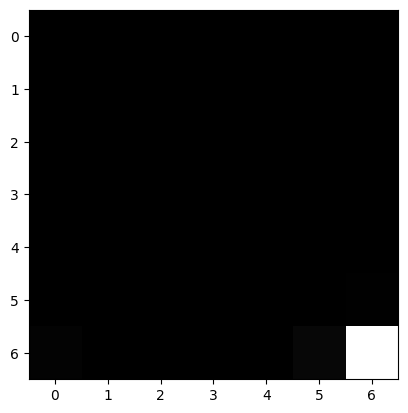

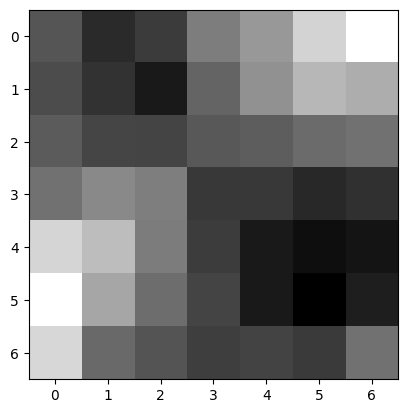

In [16]:
i = 60 
j = 60
k = 80

channel = 0

lr_patch = np.copy(subjects_lr[6][
                        i - p_size_i - e_or_o : i + p_size_i,
                        j - p_size_i - e_or_o : j + p_size_i,
                        k - p_size_i - e_or_o : k + p_size_i, :])

hr_patch = np.copy(subjects_hr[6][
                        i - p_size_o - e_or_o : i + p_size_o,
                        j - p_size_o - e_or_o : j + p_size_o,
                        k - p_size_o - e_or_o : k + p_size_o, :])

lr_mask = subjects_masks[6][
                            i - p_size_i - e_or_o : i + p_size_i,
                            j - p_size_i - e_or_o : j + p_size_i,
                            k - p_size_i - e_or_o : k + p_size_i]

lr_patch[lr_mask == 0] = 0

generated_image = generator(lr_patch[None,...], training=False)

print(discriminator(generated_image))

print(discriminator(hr_patch[None,...]))

plt.imshow(generated_image[0,:,:,3,channel],cmap='gray')
plt.figure()
plt.imshow(hr_patch[:,:,3,channel],cmap='gray')

In [17]:
# subjects_lr
# subjects_hr
# subjects_masks

result_image = np.zeros(hires_output.shape)

for (i, j, k) in tqdm(sel_indices[np.where(sel_indices[:,0]==6),1:].squeeze()):

    lr_patch = np.copy(subjects_lr[6][
                            i - p_size_i - e_or_o : i + p_size_i,
                            j - p_size_i - e_or_o : j + p_size_i,
                            k - p_size_i - e_or_o : k + p_size_i, :])

    lr_mask = subjects_masks[6][
                                i - p_size_i - e_or_o : i + p_size_i,
                                j - p_size_i - e_or_o : j + p_size_i,
                                k - p_size_i - e_or_o : k + p_size_i]

    lr_patch[lr_mask == 0] = 0

    generated_image = generator(lr_patch[None,...], training=False)

    result_image[i - p_size_o - e_or_o : i + p_size_o,
                 j - p_size_o - e_or_o : j + p_size_o,
                 k - p_size_o - e_or_o : k + p_size_o, :] = generated_image

result_image[subjects_masks[6] == 0] = 0
    

100%|██████████████████████████████████████| 2573/2573 [00:04<00:00, 565.30it/s]


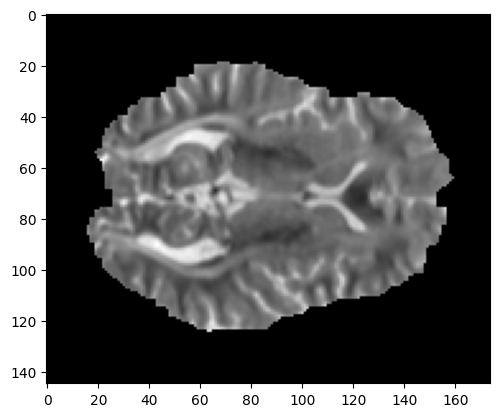

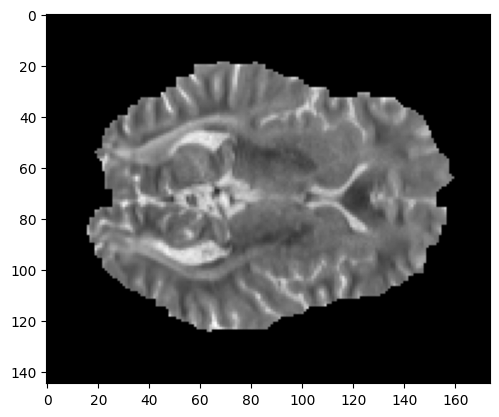

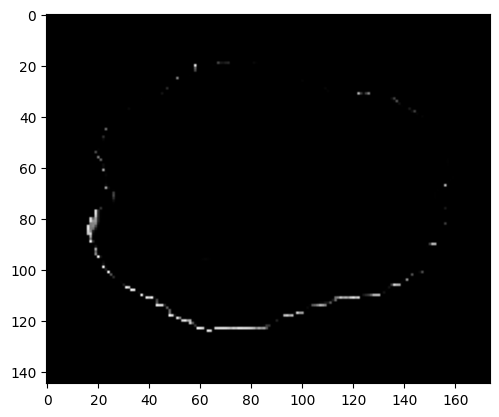

In [18]:
zdim = 60
channel = 3

# plt.imshow(subjects_masks[6][:,:,zdim], cmap='gray')
# plt.figure()
plt.imshow(subjects_lr[6][:,:,zdim,channel], cmap='gray')
plt.figure()
plt.imshow(subjects_hr[6][:,:,zdim,channel], cmap='gray')
plt.figure()
plt.imshow(result_image[:,:,zdim,channel], cmap='gray')
# plt.imshow((result_image[:,:,zdim,channel])*subjects_masks[6][:,:,zdim], cmap='gray')

2.048016271824888e-18


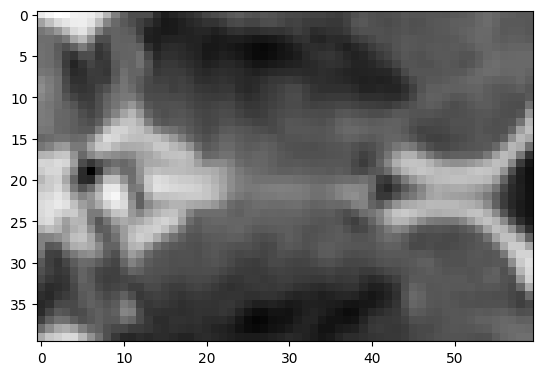

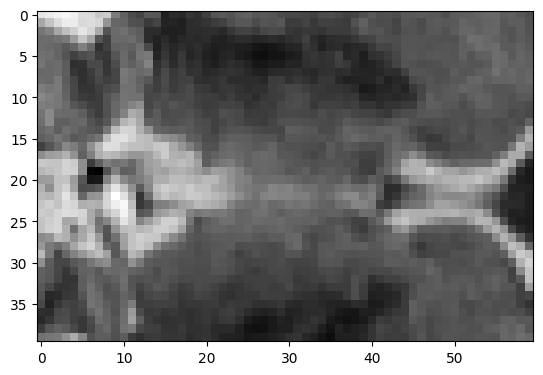

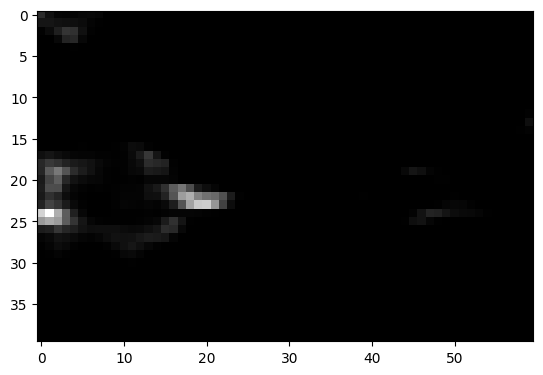

In [19]:
plt.imshow(subjects_lr[6][50:90,60:120,zdim,channel], cmap='gray')
plt.figure()
plt.imshow(subjects_hr[6][50:90,60:120,zdim,channel], cmap='gray')
plt.figure()
plt.imshow(result_image[50:90,60:120,zdim,channel], cmap='gray')

print(np.min(result_image[40:80,60:120,zdim,channel]))

In [20]:
# generator.save_weights('Model/gen_weights')
# discriminator.save_weights('Model/disc_weights')

In [21]:
generator.save('Model/generator5x_dti_norm')
discriminator.save('Model/discriminator5x_dti_norm')

INFO:tensorflow:Assets written to: Model/generator5x_dti_norm/assets


INFO:tensorflow:Assets written to: Model/generator5x_dti_norm/assets


INFO:tensorflow:Assets written to: Model/discriminator5x_dti_norm/assets


INFO:tensorflow:Assets written to: Model/discriminator5x_dti_norm/assets
